# Installing important module

In [1]:
%pip install tensorflow backend
%pip install tensorflow keras
import tensorflow as tf

2024-04-14 19:26:47.522511: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 19:26:48.844490: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 19:26:52.197183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 19:26:55.852829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Importing modules

In [15]:
import keras
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Installing Kaggle for importing its dataset using the API

In [16]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


# Creating a Directory and moving kaggle.json file to it

In [17]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/home/codespace/.kaggle/kaggle.json': No such file or directory


# Downloading the ASL dataset from kaggle using there API command

In [18]:
!kaggle datasets download -d datamunge/sign-language-mnist

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


# Extracting the dataset

In [19]:
from zipfile import ZipFile
dataset = "sign-language-mnist.zip"
with ZipFile(dataset, "r") as zip:
    zip.extractall()
    print("data is extracted")

data is extracted


# Now we can play with the data!

Use Pandas to read CSV files of train and test

In [20]:
train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")

Use Head command to view first five rows of the dataset

In [21]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization and Preprocessing

<Axes: xlabel='label', ylabel='count'>

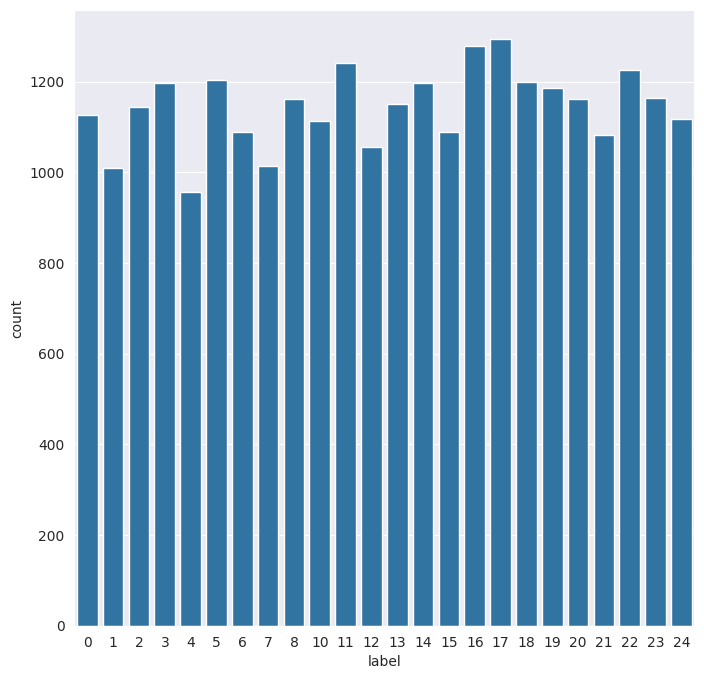

In [22]:
plt.figure(figsize=(8,8)) # set any size you want
sns.set_style("darkgrid") # we can use white,dark,whitegrid,darkgrid,ticks etc as per our requirements
sns.countplot(data=train_df, x="label")

The dataset seems balanced as for each training label , enough training examples exist

In [23]:
train_df_only_labels = train_df["label"]
test_df_only_labels =  test_df["label"]
del train_df["label"]
del test_df["label"]

In [24]:
LabelBinarizer = LabelBinarizer()
y_train = LabelBinarizer.fit_transform(train_df_only_labels) # this convert all the labels in binary form: (0s and 1s)
y_test = LabelBinarizer.fit_transform(test_df_only_labels)

Now I will assign all the values of the dataset except the "labels" to the new variables

In [25]:
x_train = train_df.values
x_test = test_df.values

Now we will perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [26]:
# Normalizing the data
x_train = x_train/255
x_test = x_test/255

Reshaping the data from 1-D to 3-D as required through input by CNN's


In [27]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Preview of first ten images

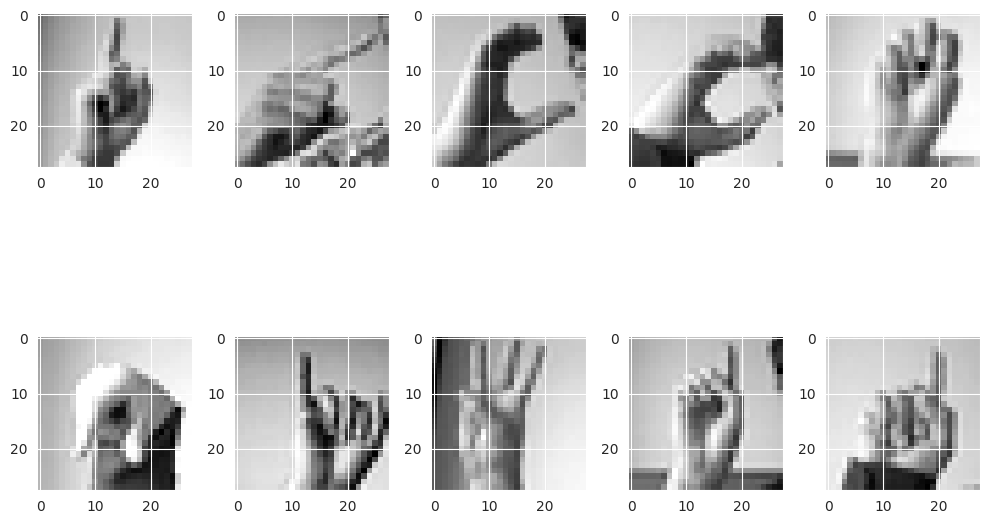

In [28]:
f, ax=plt.subplots(2, 5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(x_train[k].reshape(28,28), cmap = "gray")
        k+=1
    plt.tight_layout()

# Data Augmentation

Using Data Augmentation to prevent overfitting

In [29]:
augmented_data = ImageDataGenerator(
    featurewise_center= False,              # set input mean to 0 over the dataset
    samplewise_center= False,               # set each sample mean to 0
    featurewise_std_normalization= False,   # divide input by the std of the dataset
    samplewise_std_normalization= False,    # divide each output by its std
    zca_whitening= False,                   # apply ZCA whitening
    rotation_range= 10,                     # randomly rotate images in the range of (0,180) degree
    zoom_range= 0.1,                        # randomly zoom images
    width_shift_range= 0.1,                 # randomly shift images horizontally (fraction of total width)
    height_shift_range= 0.1,                # randomly shift images vertically (fraction of total height)
    horizontal_flip= False,                 # randomly flip images
    vertical_flip= False,                   # randomly flip images
)
augmented_data.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

# CONVOLUTIONAL NEURAL NETWORKS
A Convolutional Neural Network(CNN) is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.

A convolution does this by multiplying two matrices and yielding a third, smaller matrix.
The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.
In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.

# Training the Model:

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [31]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,049 (1.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

In [32]:
# model = Sequential()
# model.add(Conv2D(250, (3,3), strides=1, padding="same", activation="relu", input_shape=(28,28,1)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2), strides=2, padding="same"))
# model.add(Conv2D(225, (3,3), strides=1, padding="same", activation="relu"))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2), strides=2, padding="same"))
# model.add(Conv2D(200, (3,3), strides=1, padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(175, (3,3), strides=1, padding="same", activation="relu"))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(150, (3,3), strides=1, padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(125, (3,3), strides=1, padding="same", activation="relu"))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(100, (3,3), strides=1, padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(75, (3,3), strides=1, padding="same", activation="relu"))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(50, (3,3), strides=1, padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(25, (3,3), strides=1, padding="same", activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Flatten())
# model.add(Dense(units=512, activation="relu"))
# model.add(Dropout(0.6))
# model.add(Dense(units=24, activation="relu"))
# model.compile(optimizer="adam", loss="categorical_crossentropy", sample_weight_mode=["accuracy"])
# model.summary()

In [33]:
history = model.fit(augmented_data.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 59s 257ms/step - accuracy: 0.4484 - loss: 1.8716 - val_accuracy: 0.1474 - val_loss: 3.3624 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 80s 254ms/step - accuracy: 0.9136 - loss: 0.2594 - val_accuracy: 0.6174 - val_loss: 1.1927 - learning_rate: 0.0010
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 59s 272ms/step - accuracy: 0.9636 - loss: 0.1106 - val_accuracy: 0.9828 - val_loss: 0.0726 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 56s 258ms/step - accuracy: 0.9798 - loss: 0.0620 - val_accuracy: 0.9884 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 55s 256ms/step - accuracy: 0.9861 - loss: 0.0428 - val_accuracy: 0.9950 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 56s 258ms/step - accuracy: 0.9886 - loss: 0.0361 - val_accuracy: 0.9559 - val_loss: 0.1074 - learning_rate: 0.0010
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9899 - loss: 

In [5]:
model.evaluate(x_test,y_test)

AttributeError: '_UserObject' object has no attribute 'evaluate'

# Saving the Model

In [41]:
tf.saved_model.save(model ,"/workspaces/ASL-Data-Science-project-CNN-using-Keras-/ASL Data Science/Model")

INFO:tensorflow:Assets written to: /workspaces/ASL-Data-Science-project-CNN-using-Keras-/ASL Data Science/Model/assets


INFO:tensorflow:Assets written to: /workspaces/ASL-Data-Science-project-CNN-using-Keras-/ASL Data Science/Model/assets


In [4]:
model = tf.saved_model.load("/workspaces/ASL-Data-Science-project-CNN-using-Keras-/ASL Data Science/Model")

# Analysis after Model Training

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
correct = np.nonzero(predictions == y)[0]

# Some of the Correctly Predicted Classes

i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1